Idee:
Aus dem Bild soll der Hintergrund herausgefiltert werden, so dass nur noch der Vordergrund bearbeitet werden muss.

Ausgangssituation:
Man kann zwar teilweise nur noch den Vordergrund anzeigen lassen, jedoch kommt auch viel vom Hintergrund mit. Die direkte Anwendung eines Kantendetektors kann somit auch andere Teile mitnehmen.

In [1]:
# OpenCV needs to be included first
import cv2
import numpy as np

# for displaying images in jupyter

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
# resolution of images in figure
mpl.rcParams['figure.dpi']= 200
# figure size in inches
mpl.rcParams["figure.figsize"] = [10,5]

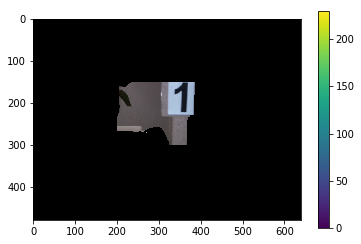

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# load the image on disk and then display it
image = cv2.imread('images/my-pic8_w-h-iso100-light-exauto.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = np.zeros(image.shape[:2],np.uint8)
   
# specify the background and foreground model 
# using numpy the array is constructed of 1 row 
# and 65 columns, and all array elements are 0 
# Data type for the array is np.float64 (default) 
backModel = np.zeros((1, 65), np.float64) 
foreModel = np.zeros((1, 65), np.float64) 
   
# define the Region of Interest (ROI) 
# as the coordinates of the rectangle 
# where the values are entered as 
# (startingPoint_x, startingPoint_y, width, height) 
# these coordinates are according to the input image 
# it may vary for different images 
rect = (200, 150, 200, 150) 
   
# apply the grabcut algorithm with appropriate 
# values as parameters, number of iterations = 3  
# cv2.GC_INIT_WITH_RECT is used because 
# of the rectangle mode is used  
cv2.grabCut(image, mask, rect,backModel, foreModel, 5, cv2.GC_INIT_WITH_RECT) 
   
# In the new mask image, pixels will  
# be marked with four flags  
# four flags denote the background / foreground  
# mask is changed, all the 0 and 2 pixels  
# are converted to the background 
# mask is changed, all the 1 and 3 pixels 
# are now the part of the foreground 
# the return type is also mentioned, 
# this gives us the final mask 
mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8') 
   
# The final mask is multiplied with  
# the input image to give the segmented image. 
image = image * mask2[:, :, np.newaxis] 
   
# output segmented image with colorbar 
plt.imshow(image) 
plt.colorbar()  

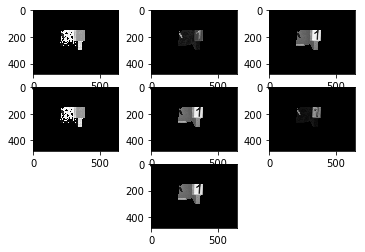

In [3]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hsv_h,hsv_s,hsv_v = cv2.split(hsv)
hls_h,hls_l,hls_s = cv2.split(hls)
plt.subplot(3, 3, 1)
plt.imshow(hsv_h, cmap='gray')
plt.subplot(3, 3, 2)
plt.imshow(hsv_s, cmap='gray')
plt.subplot(3, 3, 3)
plt.imshow(hsv_v, cmap='gray')
plt.subplot(3, 3, 4)
plt.imshow(hls_h, cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(hls_l, cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(hls_s, cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(gray, cmap='gray')

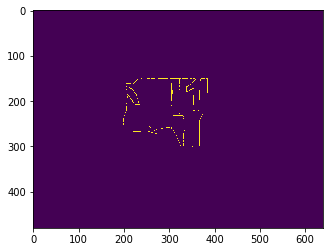

In [4]:
# convert the color image into grayscale
grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find edges in the image using canny edge detection method
# Calculate lower threshold and upper threshold using sigma = 0.33
v = np.median(grayScale)
low = 40
high = 220

edged = cv2.Canny(grayScale, low, high)

plt.imshow(edged)

271 271 pentagon
298 213 circle


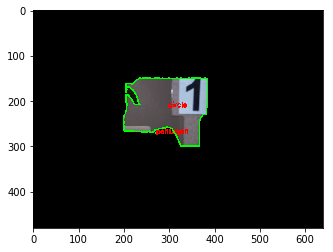

In [5]:
# After finding edges we have to find contours
# Contour is a curve of points with no gaps in the curve
# It will help us to find location of shapes

# cv2.RETR_EXTERNAL is passed to find the outermost contours (because we want to outline the shapes)
# cv2.CHAIN_APPROX_SIMPLE is removing redundant points along a line
(_, cnts, _) = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


'''
We are going to use contour approximation method to find vertices of
geometric shapes. The alogrithm  is also known as Ramer Douglas Peucker alogrithm.
In OpenCV it is implemented in cv2.approxPolyDP method.abs
detectShape() function below takes a contour as parameter and
then returns its shape
 '''


def detectShape(cnt):
    shape = 'unknown'
    # calculate perimeter using
    peri = cv2.arcLength(c, True)
    # apply contour approximation and store the result in vertices
    vertices = cv2.approxPolyDP(c, 0.04 * peri, True)

    # If the shape it triangle, it will have 3 vertices
    if len(vertices) == 3:
        shape = 'triangle'

    # if the shape has 4 vertices, it is either a square or
    # a rectangle
    elif len(vertices) == 4:
        # using the boundingRect method calculate the width and height
        # of enclosing rectange and then calculte aspect ratio

        x, y, width, height = cv2.boundingRect(vertices)
        aspectRatio = float(width) / height

        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        if aspectRatio >= 0.95 and aspectRatio <= 1.05:
            shape = "square"
        else:
            shape = "rectangle"

    # if the shape is a pentagon, it will have 5 vertices
    elif len(vertices) == 5:
        shape = "pentagon"

    # otherwise, we assume the shape is a circle
    else:
        shape = "circle"

    # return the name of the shape
    return shape


# Now we will loop over every contour
# call detectShape() for it and
# write the name of shape in the center of image

# loop over the contours
for c in cnts:
    # compute the moment of contour
    M = cv2.moments(c)
    if(M['m00']!=0.0):
        # From moment we can calculte area, centroid etc
        # The center or centroid can be calculated as follows
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])

        # call detectShape for contour c
        shape = detectShape(c)
        
        print(cX, cY, shape)

        # Outline the contours
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

        # Write the name of shape on the center of shapes
        cv2.putText(image, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # show the output image
        plt.imshow(image)
        

